# Prompts定义的目标物体掩码

SAM通过prompts指定的位置来预测目标的掩码。SAM模型首先将图像转换为图像特征，该图像特征允许从prompts有效地生成高质量的掩模。

`SamPredictor`类为模型提供了一个简单的接口，用于提示模型。它允许用户首先使用`set_image`方法设置图像，该方法计算必要的图像特征。然后，可以通过`predict`方法提供prompts，然后模型可以根据这些prompts有效地预测掩码。该模型可以将点提示和框提示以及上一次预测迭代中的掩码作为输入。

## 设置

用于显示点、框和mask的功能函数。

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## 示例图片

In [3]:
image = cv2.imread('./images/groceries.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

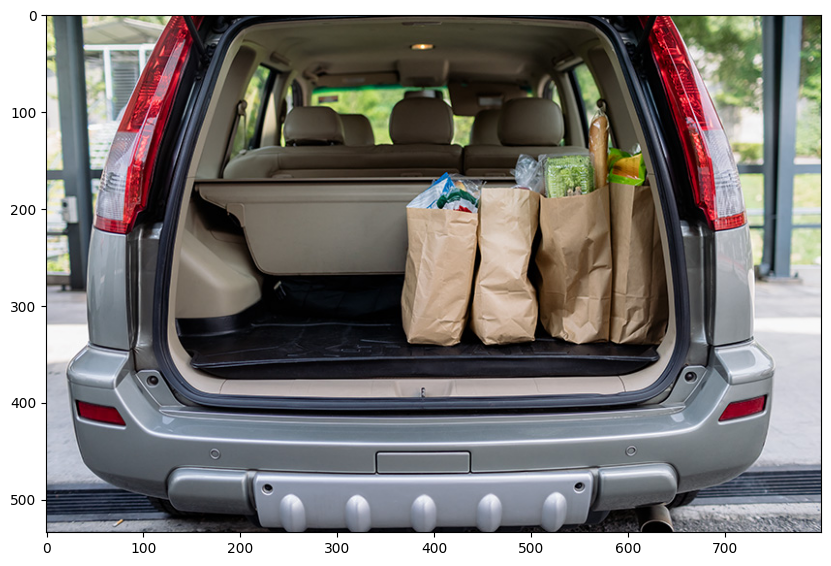

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 通过prompts来选择物体

首先，加载SAM的模型和predictor。需要更改一下路径。

In [7]:
MODELS_FOLDER = os.getenv('MODEL_FOLDER_PATH')
model_folder_path= MODELS_FOLDER
OUR_UNET1_MODEL_File = os.path.join(model_folder_path+'sam_vit_h_4b8939.pth')
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = OUR_UNET1_MODEL_File
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

通过调用`SamPredictor.set_image`处理图像以生成图像特征。`SamPredictor`会记住这个特征，并将其用于后续的掩码预测。

In [8]:
predictor.set_image(image)

为了选择图中的卡车，我们需要在卡车上选择一个点。点以（x，y）格式输入到模型中，并带有标签1（前景点）或0（背景点）。方法支持输入多个点；这里我们只使用一个点，所选的点在图像上显示为星形。

In [9]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

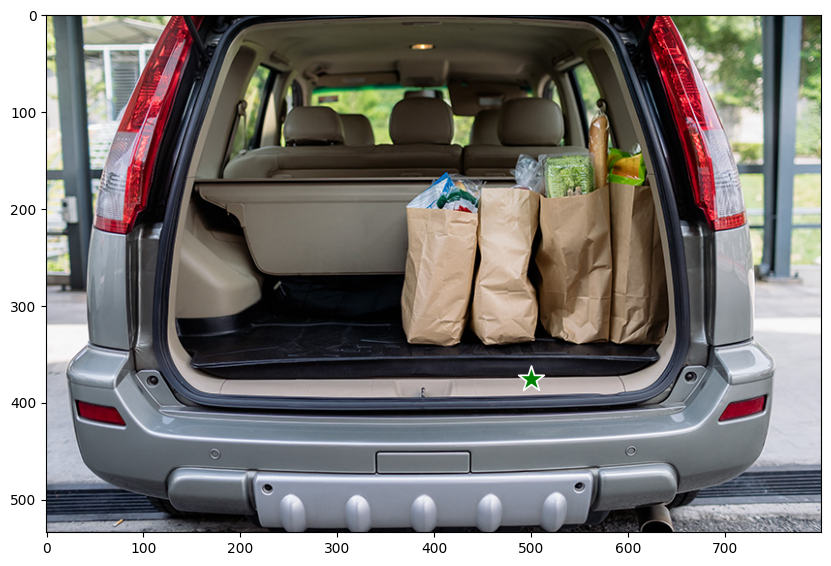

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

使用`SamPredictor.predict`进行预测。该模型返回掩码、掩码的质量预测以及可以传递到下一次预测迭代的低分辨率掩码预测。

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

在`multimask_output=True`（默认设置）的情况下，SAM输出3个掩码，其中`scores`给出了模型自己对这些掩码质量的估计。此设置用于不明确的输入提示，并帮助模型消除对象的歧义。当为“False”时，它将返回1个掩码。即使只需要一个掩码，对于不明确的提示，如单个点，建议使用“multimask_output=True”。可以通过选择在`scores`中返回的分数最高的一个mask来作为最佳的掩码。

In [12]:
masks.shape  # (number_of_masks) x H x W

(3, 534, 800)

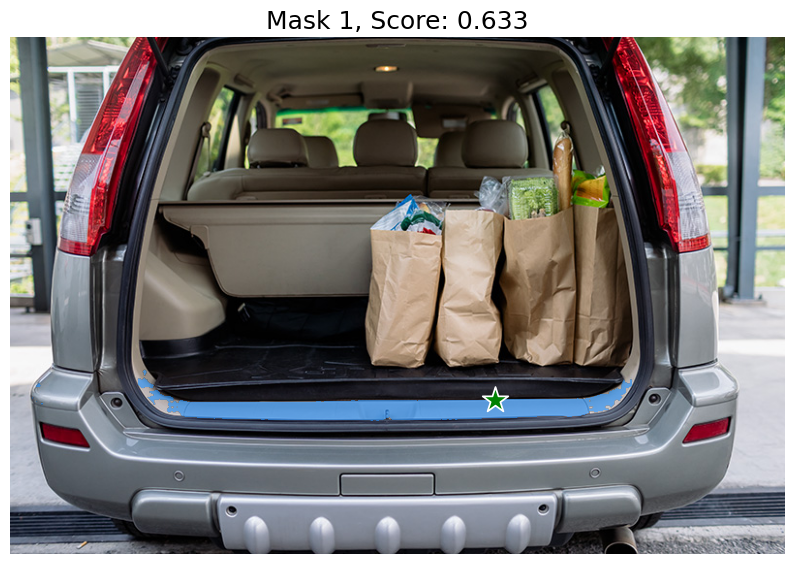

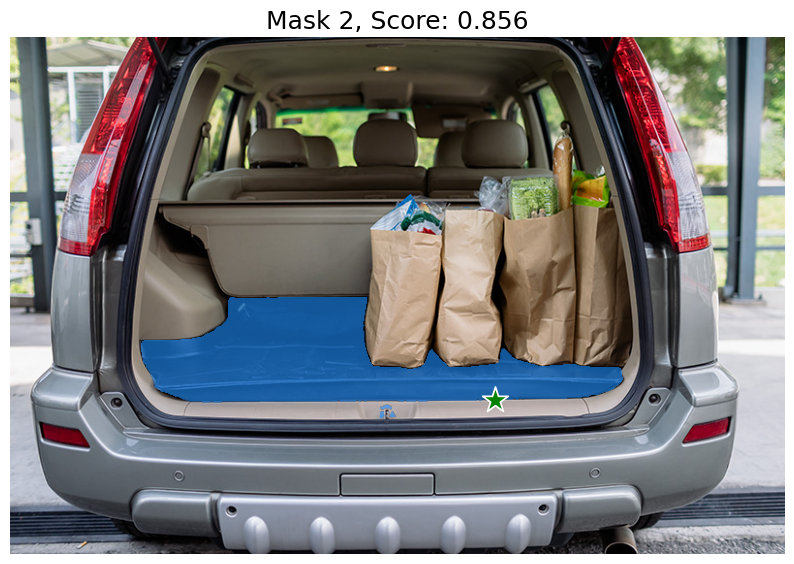

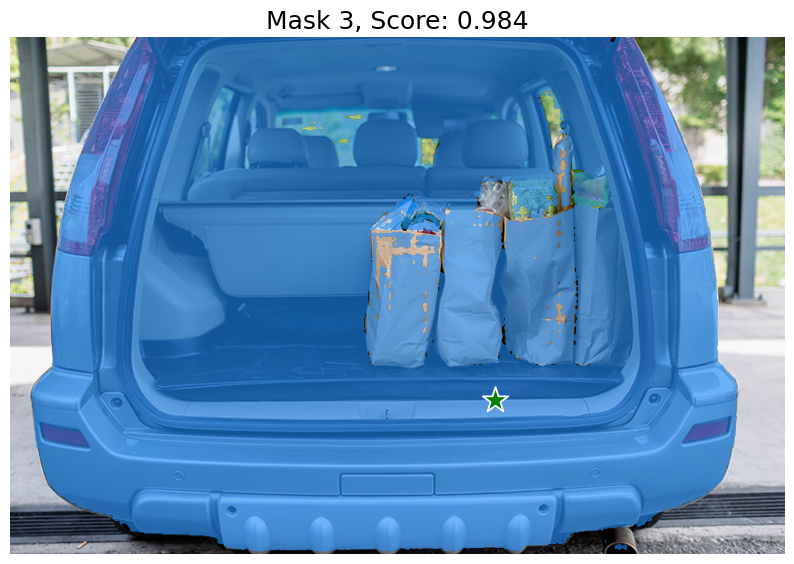

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## 通过额外的点来指定一个特定的目标

单个输入点所指定的目标是不明确的，因此模型默认返回与其类似的多个对象。要获得单个对象，可以给模型提供多个点。此外，先前迭代的掩码也可以提供给模型以帮助预测。当使用多个prompts指定单个对象时，可以通过设置`multimask_output=False`来请求单个掩码。

In [14]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [15]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [16]:
masks.shape

(1, 534, 800)

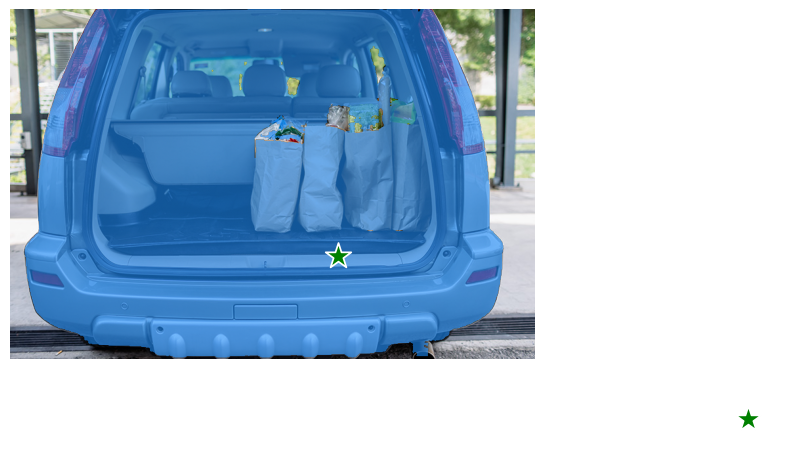

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

要排除汽车并仅指定车窗，可以提供``背景点``（标签为0，此处显示为红色）。

In [19]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [18]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

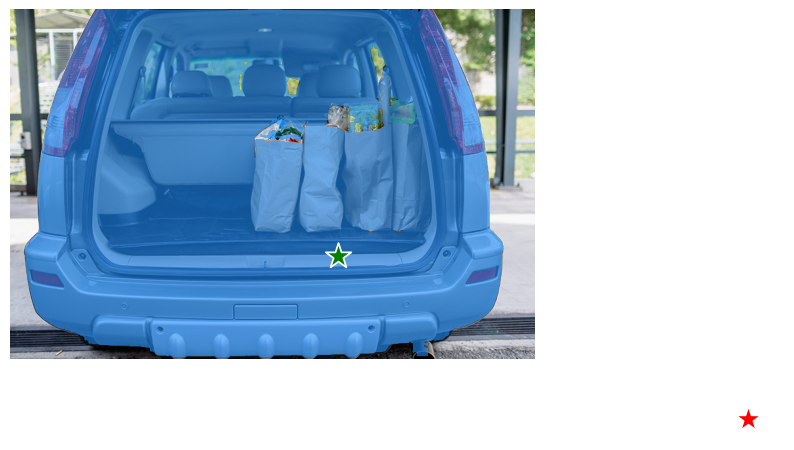

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## 通过框来指定一个物体

模型也支持输入一个框，输入的框是xyxy格式。

In [21]:
input_box = np.array([425, 600, 700, 875])

In [22]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

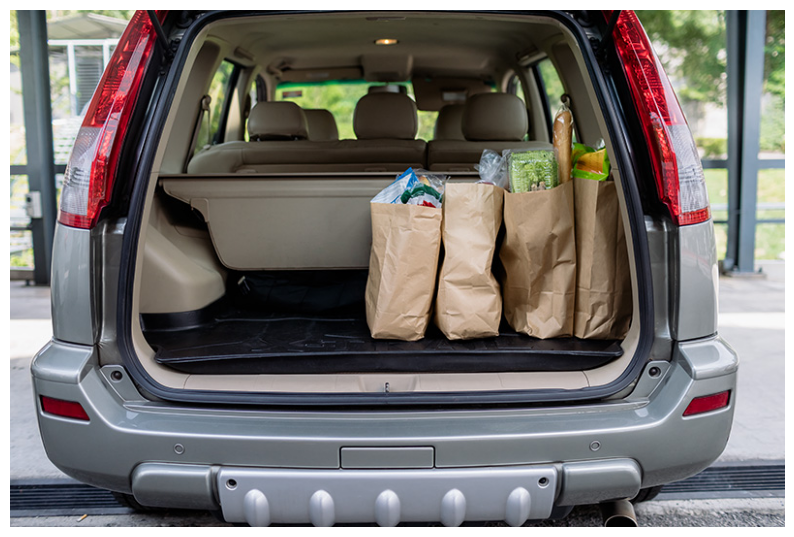

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## 组合点和框

点和框可以组合，只需将这两种类型的提示都输入预测器中即可。在示例图片中，我们可以只选择卡车的轮胎，而不是整个车轮。

In [24]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [25]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

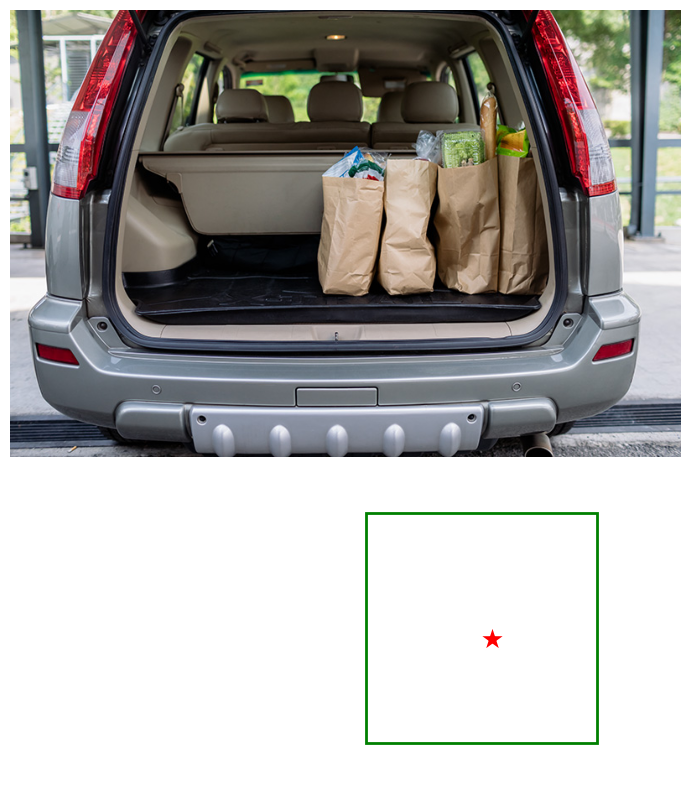

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## 批量的prompts输入

SamPredictor可以使用`predict_torch`方法对同一图像进行多个输入提示。该方法假设输入点已经是torch的张量，并且已经被转换为输入帧。例如，假设我们有几个来自目标检测算法的框。

In [27]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

将框转换为输入帧，然后预测masks。`SamPredictor`将必要的变换存储为transform`字段，方便我们调用。

In [28]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [29]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([4, 1, 534, 800])

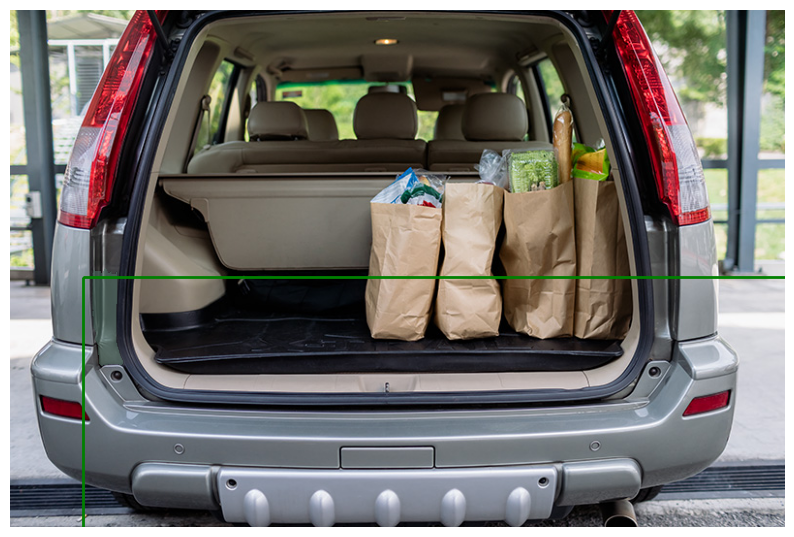

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## 端到端的批处理

如果我们提前准备好了所有的prompts，则可以直接以端到端方式运行SAM，于是我们可以对图像进行批处理。

In [32]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

图像和promtps都作为PyTorch张量输入，这些张量已经转换为正确的帧。输入被打包为图像的列表，每个元素都是一个dict，它包括以下键：
* `image`: 输入的图像，它是CHW格式的PyTorch张量
* `original_size`: 图像转换为SAM输入之前的大小，格式为（H，W）
* `point_coords`: 批量的点提示
* `point_labels`: 批量的点提示的标签
* `boxes`: 批量的框
* `mask_inputs`: 批量的输入mask

如果某一类的prompt不存在，则可以去掉这个key。

In [34]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [35]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

运行模型

In [36]:
batched_output = sam(batched_input, multimask_output=False)